## ATL07 Data Access Tutorial

First we need to install all the necessary python packages

In [ ]:
# Mount our Google Drive so we can save and edit files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install icepyx

In [ ]:
# ! pip install git+https://github.com/SciTools/cartopy.git
! pip install cartopy --no-binary cartopy
! pip uninstall shapely 
! pip install shapely --no-binary shapely

Uninstalling Shapely-1.7.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Shapely-1.7.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/shapely/*
Proceed (y/n)? y
  Successfully uninstalled Shapely-1.7.1
     |████████████████████████████████| 389kB 11.9MB/s 
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for shapely ... done


In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py
from scipy.interpolate import interp1d
from astropy.time import Time
import os
import icepyx as ipx

ModuleNotFoundError: ignored

Let's download some IceSat-2 ATL07 data using icepyx

In [ ]:
# define region "bounding box" and time period 
short_name = 'ATL07'
spatial_extent = [-55, 68, -48, 71] # this is a list of lats and lons
date_range = ['2019-02-20','2019-02-28']

In [ ]:
# build the query object - this object is a standardised way to tell icepyx what data you're looking for
region_a = ipx.Query(short_name, spatial_extent, date_range)

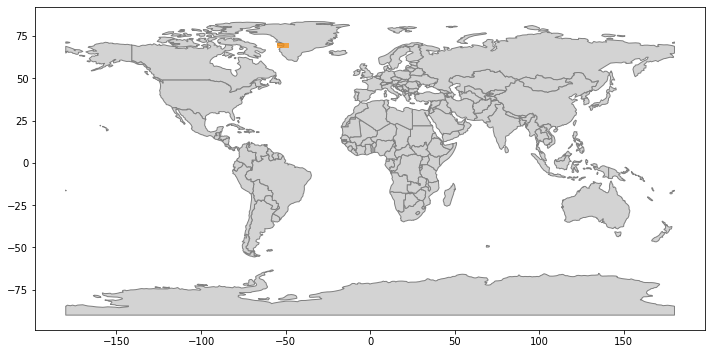

In [ ]:
# (otional) visualize region on a map
region_a.visualize_spatial_extent()

In [ ]:
# (optional) display some details about the dataset
print(region_a.dataset_summary_info())
print('latest version:', region_a.latest_version())

dataset_id :  ATLAS/ICESat-2 L3A Sea Ice Height V003
short_name :  ATL07
version_id :  003
time_start :  2018-10-14T00:00:00.000Z
coordinate_system :  CARTESIAN
summary :  The data set (ATL07) contains along-track heights for sea ice and open water leads (at varying length scales) relative to the WGS84 ellipsoid (ITRF2014 reference frame) after adjustment for geoidal and tidal variations, and inverted barometer effects. Height statistics and apparent reflectance are also provided. The data were acquired by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory.
orbit_parameters :  {'swath_width': '36.0', 'period': '94.29', 'inclination_angle': '92.0', 'number_of_orbits': '1.0', 'start_circular_latitude': '0.0'}
None
latest version: 003


In [ ]:
# build and view the parameters that will be submitted in our query
region_a.CMRparams

{'bounding_box': '-55.0,68.0,-48.0,71.0',
 'short_name': 'ATL07',
 'temporal': '2019-02-20T00:00:00Z,2019-02-28T23:59:59Z',
 'version': '003'}

In [ ]:
# provide your sign-in credentials - you'll be propted for your password
earthdata_uid = 'your.username'
email = 'your.email@phony.com'
region_a.earthdata_login(earthdata_uid, email)

Earthdata Login password: ··········


In [ ]:
# define a path where you want your data saved
path = '/content/drive/MyDrive/ColabNotebooks/IS2_data/'

In [ ]:
# download the data 
region_a.download_granules(path)

Total number of data order requests is  1  for  4  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000990637
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000990637 of  1  order(s) is downloaded.
Download complete


That's it! We've just downloaded our first bit of ATL07 Data! \\
Here's some ddocumentation on the IceSat-2 data products https://nsidc.org/sites/nsidc.org/files/ATL07-V003-UserGuide.pdf

In [2]:
# we'll choose one file to start with 
atl_file = 'processed_ATL07-01_20190225115500_09020201_003_02.h5'

In [3]:
# open the sample file using h5py
f = h5py.File(path + atl_file, 'r')

NameError: ignored

In [ ]:
def get_keys_recursive(obj, _lvl=0):
    '''
    Returns a string representation of the file structure
    within an hdf5 object
    '*' character indicates a non-directory object
    :param obj: an open hdf5 object
    :param _lvl: current indentation level
    :return: string
    '''
    pathstr = obj.name
    if not pathstr == '/':
        pathstr = pathstr.split('/')[-1]

    try:
        keys = obj.keys()
        if keys == []:
            return + pathstr
        for i in keys:
            # print(i)
            pathstr += '\n' + '\t'*_lvl + get_keys_recursive(obj[i], _lvl+1)
        return pathstr

    except:
        # pass
        return '*' + pathstr


hdf5 files have a nested file srtucture. The function above returns a string visually showing the nested attributes witin our file so we can read them into a more convenient data structure later.

In [1]:
print(get_keys_recursive(f))

NameError: ignored

In [ ]:
def getATL07(f,beam):
  '''
  This function assumes the structure of an ATL07 file and reads some of the 
  parameters we may commonly use into a pandas dataframe so we can use it more
  easily.
  You may want to customise this to suit your research needs
  '''
  lats = f[beam+'/sea_ice_segments/latitude'][:]
  lons = f[beam+'/sea_ice_segments/longitude'][:]
  dt = f[beam+'/sea_ice_segments/delta_time'][:]
  seg_x = f[beam+'/sea_ice_segments/seg_dist_x'][:]
  heights = f[beam+'/sea_ice_segments/heights/height_segment_height'][:]
  conf = f[beam+'/sea_ice_segments/heights/height_segment_confidence'][:]
  stype = f[beam+'/sea_ice_segments/heights/height_segment_type'][:]
  ssh_flag = f[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:]
  gauss = f[beam+'/sea_ice_segments/heights/height_segment_w_gaussian'][:]
  photon_rate = f[beam+'/sea_ice_segments/stats/photon_rate'][:]
  cloud = f[beam+'/sea_ice_segments/stats/cloud_flag_asr'][:]
  mss = f[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:]
  ocean_tide = f[beam+'/sea_ice_segments/geophysical/height_segment_ocean'][:]
  lpe_tide = f[beam+'/sea_ice_segments/geophysical/height_segment_lpe'][:]
  ib = f[beam+'/sea_ice_segments/geophysical/height_segment_ib'][:]
  df07=pd.DataFrame({'lats':lats,
                      'lons':lons,
                      'heights':heights,
                      'dt':dt,
                      'conf':conf,
                      'stype':stype,
                      'ssh_flag':ssh_flag,     
                      'gauss':gauss,
                      'photon_rate':photon_rate,
                      'cloud':cloud,
                      'mss':mss,
                      'ocean':ocean_tide,
                      'lpe':lpe_tide,
                      'ib':ib})
  return df07

In [ ]:
# as an example, lets read in the first beam on the left
# valid beam names: gt1l, gt1r, gt2l, gt2r, gt3l, gt3r 
beam = getATL07(f, 'gt1l')
beam.head() # displays the first few rows in a table

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss,ocean,lpe,ib
0,69.319402,-51.082952,3.402823e+38,3.633199e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,4,23.803707,3.402823e+38,3.402823e+38,0.195684
1,69.319402,-51.082952,3.402823e+38,3.633199e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,4,23.803707,3.402823e+38,3.402823e+38,0.195684
2,69.319402,-51.082952,3.402823e+38,3.633199e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,4,23.803707,3.402823e+38,3.402823e+38,0.195684
3,69.319402,-51.082952,3.402823e+38,3.633199e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,4,23.803707,3.402823e+38,3.402823e+38,0.195684
4,69.319402,-51.082952,3.402823e+38,3.633199e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,4,23.803707,3.402823e+38,3.402823e+38,0.195684


# Let's try plotting some of the data

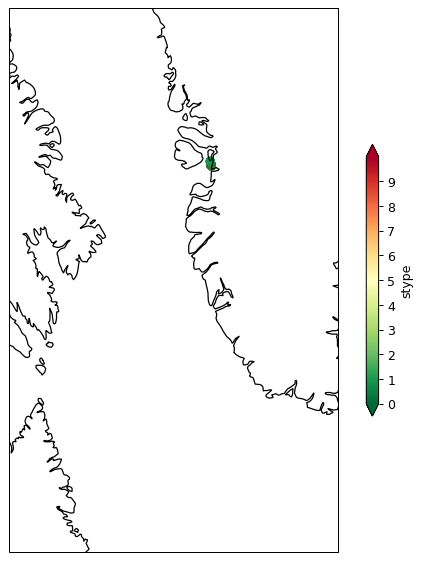

In [ ]:
var = 'stype' 

#Set colorbar ranges based on the chosen parameter
vmin=0
vmax=10
ticks=np.arange(vmin,vmax,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-55)) # choose polar sterographic for projection
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-65, -45, 55, 75], ccrs.PlateCarree())
plt.scatter(beam['lons'], beam['lats'],c=beam[var], cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

# Exercise: Zoom in on the data shown. Colour in the land and water. Choose a different colour map

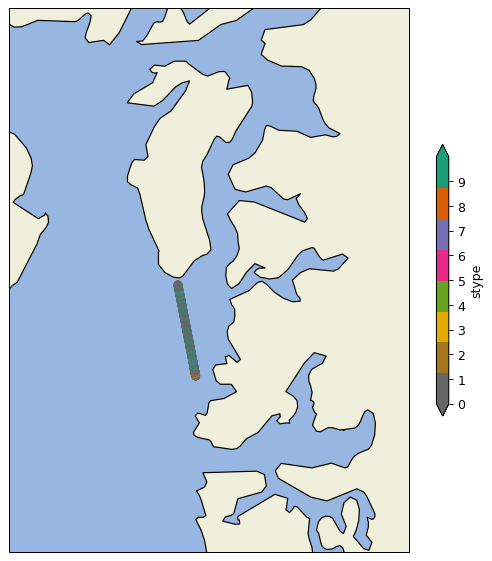

In [ ]:
var = 'stype' 

#Set colorbar ranges based on the chosen parameter
vmin=0
vmax=10
ticks=np.arange(vmin,vmax,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-55)) # choose polar sterographic for projection
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-52, -50, 69, 70], ccrs.PlateCarree())
plt.scatter(beam['lons'], beam['lats'],c=beam[var], cmap=plt.cm.get_cmap('Dark2').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');


# Exercise: Add the 5 other beams to the plot above

# Exercise: Read through all of the files we downloaded and plot them all on the same figure

There are various recognised surface types. They are flagged by numbers 0-9 inclusive. 

* 0: cloud covered
* 1: other
* 2: specular lead (low) w/bkg
* 3: specular lead (low)
* 4: specular lead (high) w/bkg
* 5: specular lead (high)
* 6: dark lead (smooth) w/bkg
* 7: dark lead (smooth)
* 8: dark lead (rough) w/bkg
* 9: dark lead (rough)



Text(0, 0.5, 'ATL07 \nsurface heights')

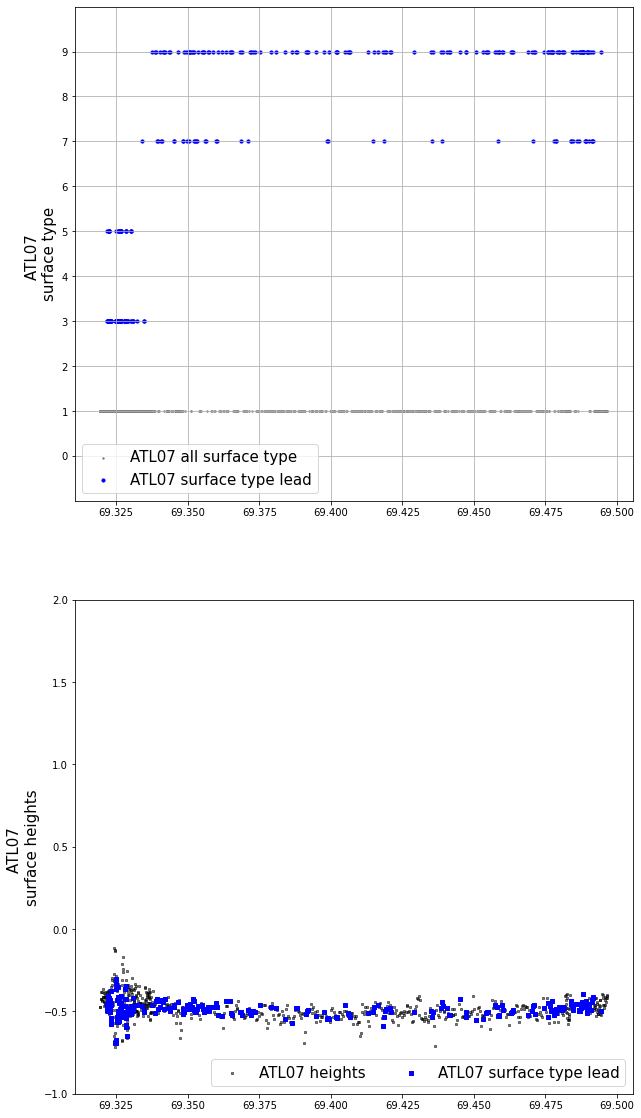

In [70]:
# let's see what some of these look like if we plot them as a function of latitude
fig,ax=plt.subplots(2,1,figsize=(10,20))

#Plot 1: Location of leads
ax[0].grid()
ax[0].scatter(beam.lats,beam.stype,s=2,c='gray',label='ATL07 all surface type')
ax[0].scatter(beam[beam.stype>1].lats,beam[beam.stype>1].stype,s=10,c='blue',label= 'ATL07 surface type lead')
ax[0].legend(fontsize=15)
ax[0].set_ylim(-1,10)
ax[0].set_ylabel('ATL07 \nsurface type',fontsize=15)
ax[0].set_yticks(np.arange(0,10,1))

#Plot 2: Sea ice segment heights 
ax[1].scatter(beam.lats,beam.heights,marker='s',s=5,c='k',alpha=.5, label= 'ATL07 heights')
ax[1].scatter(beam[beam.stype>1].lats,beam[beam.stype>1].heights,marker='s',s=10,c='b', label= 'ATL07 surface type lead')
ax[1].legend(ncol=2, loc=4,fontsize=15)
ax[1].set_ylim(-1,2)
ax[1].set_ylabel('ATL07 \nsurface heights',fontsize=15)


# Exercise: Modify the code above to include a third plot of the confidence level of each recorded height